In [1]:
import rebound
from spock import FeatureClassifier
feature_model = FeatureClassifier()

[16:41:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1662013816914/work/src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


Values from Suárez Mascareño + 2022

In [2]:
from scipy.stats import uniform, norm, truncnorm
import astropy.units as u
import numpy as np

Mstar = 1.095 # + 0.049 - 0.047
planets = "b c d e".split()
Nplanets = len(planets)
#b,c,d,e
pers = [24.1399, 8.24892, 12.4058, 40.2]
pers_err = [0.0015, 0.00083, 0.0018, 1.0]

eccs = [0.134, 0.30, 0.20, 0.10]          #upper limit if sig is NaN
eccs_err = [0.075, np.nan, np.nan, 0.091]

mps = [0.64, 0.24, 0.31, 1.16]
mps_err = [0.19, np.nan, np.nan, 0.30]

In [3]:
import astropy.units as u
Mj2Ms = u.Mjup.to(u.Msun)

def setup_sim(mps, pers, eccs=eccs):
    assert len(mps)==len(pers)==len(eccs)==Nplanets
    sim = rebound.Simulation()
    sim.units = ["msun", "m", "d"]
    sim.add(m=Mstar)
    for i in range(Nplanets):
        sim.add(m=mps[i]*Mj2Ms, P=pers[i], e=eccs[i])
    sim.move_to_com()
    return sim

In [4]:
s=setup_sim(mps,pers)
s

### single sim

In [5]:
%timeit feature_model.predict_stable(s, n_jobs=1)

167 ms ± 28.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit feature_model.predict_stable(s, n_jobs=40)

165 ms ± 4.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### parallel sims

In [7]:
%timeit feature_model.predict_stable([s,s,s], n_jobs=1)

562 ms ± 48.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit feature_model.predict_stable([s,s,s], n_jobs=40)

309 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Generate samples

In [9]:
Nsamples = 5_000

### mass

In [10]:
mvec=[]
for i in range(Nplanets):
    mu, sigma = mps[i], mps_err[i]
    if sigma is np.nan:
        v=uniform(loc=0, scale=mu).rvs(size=Nsamples)*Mj2Ms
    else:
        lower = 1*u.Mearth.to(u.Mjup)
        upper = mu+5*sigma
        a = (lower - mu) / sigma
        b = (upper - mu) / sigma
        v=truncnorm(a=a, b=b, loc=mu, scale=sigma).rvs(size=Nsamples)*Mj2Ms
    mvec.append(v)
mvec=np.c_[mvec].T
mvec

array([[5.43015351e-04, 8.15912952e-05, 2.08206655e-04, 1.19741003e-03],
       [8.40540742e-04, 1.10217841e-05, 1.90456666e-04, 9.49413828e-04],
       [6.58045310e-04, 1.80470083e-04, 2.28952402e-04, 6.04857924e-04],
       ...,
       [5.54631053e-04, 1.91455244e-04, 1.41822871e-04, 9.57345690e-04],
       [7.95655805e-04, 2.06830003e-04, 1.54287456e-04, 9.79101004e-04],
       [5.36678244e-04, 6.70894379e-06, 2.93495826e-04, 5.97749551e-04]])

### period

In [11]:
pvec=[norm(loc=pers[i], scale=pers_err[i]).rvs(size=Nsamples) for i in range(Nplanets)]
pvec=np.c_[pvec].T
pvec

array([[24.13634472,  8.24922882, 12.40255234, 39.8470774 ],
       [24.13887562,  8.2474127 , 12.40655687, 41.02272365],
       [24.14152047,  8.2479115 , 12.40189449, 39.28792479],
       ...,
       [24.14176413,  8.24834922, 12.40523684, 41.49936375],
       [24.13807516,  8.24996171, 12.4017115 , 39.43124917],
       [24.13855285,  8.24805097, 12.40837798, 40.00773155]])

### ecc

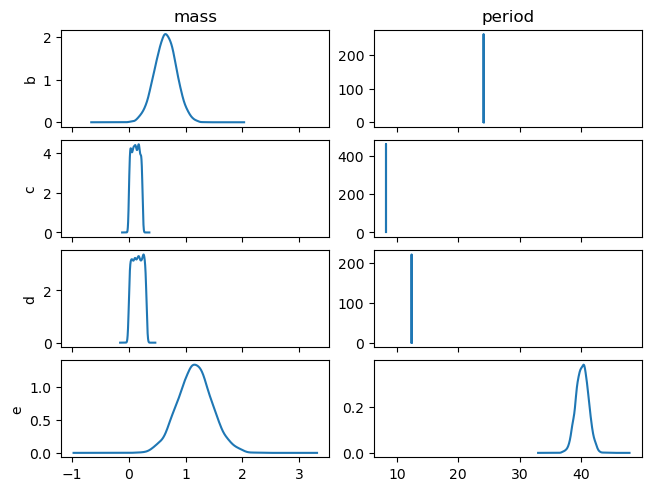

In [12]:
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline

params = ["mass","period"]
Nparams = len(params)
fig,axes = pl.subplots(Nplanets, Nparams, sharex='col', constrained_layout=True)

fac = u.Msun.to(u.Mjup)
for i,(lbl,par) in enumerate(zip(params,[mvec*fac,pvec])):
    df = pd.DataFrame(par, columns=planets)
    for j,p in enumerate(planets):
        ax=axes[j,i]
        df[p].plot.kde(ax=ax)
        if j==0:
            ax.set_title(lbl)
        if i==0:
            ax.set_ylabel(p)       
        else:
            ax.set_ylabel("")       

### get samples to make course grid

In [13]:
def evenly_select(arr, M):
    "select M evenly-spaced samples from distribution"
    N = len(arr)
    if M > N/2:
        cut = np.zeros(N, dtype=bool)
        q, r = divmod(N, N-M)
        indices = [q*i + min(i, r) for i in range(N-M)]
        cut[indices] = True
    else:
        cut = np.ones(N, dtype=bool)
        q, r = divmod(N, M)
        indices = [q*i + min(i, r) for i in range(M)]
        cut[indices] = False

    return arr[~cut]

Nsamples = 3

mvec2,pvec2,evec2 = [],[],[]
for p in range(Nplanets):
    s = np.sort(mvec[:, p])
    ss=evenly_select(s, Nsamples)
    mvec2.append(ss)
    
    s = np.sort(pvec[:, p])
    ss=evenly_select(s, Nsamples)
    pvec2.append(ss)
    
#     s = np.sort(evec[:, p])
#     ss=evenly_select(s, Nsamples)
#     evec2.append(ss)
    
mvec2 = np.array(mvec2)
pvec2 = np.array(pvec2)
# evec2 = np.array(evec2)

In [14]:
mvec2.shape, pvec2.shape#, evec2.shape

((4, 3), (4, 3))

In [ ]:
import pandas as pd

Ms2Me = u.Msun.to(u.Mearth)
pd.DataFrame(np.c_[mvec2].T*Ms2Me, columns=planets)

In [16]:
import pandas as pd

pd.DataFrame(np.c_[pvec2].T, columns=planets)

,b,c,d,e
0,24.135128,8.245986,12.398753,36.739642
1,24.139255,8.248549,12.405040,39.759359
2,24.140543,8.249283,12.406582,40.646762


In [17]:
m1s = mvec2[0]
m2s = mvec2[1]
m3s = mvec2[2]
m4s = mvec2[3]

p1s = pvec2[0]
p2s = pvec2[1]
p3s = pvec2[2]
p4s = pvec2[3]

# e1s = evec2[0]
# e2s = evec2[1]
# e3s = evec2[2]
# e4s = evec2[3]

In [18]:
c=0
vals=[]
sims=[]
for m1 in m1s:
    for m2 in m2s:
        for m3 in m3s:
            for m4 in m4s:
                for p1 in p1s:
                    for p2 in p2s:
                        for p3 in p3s:
                            for p4 in p4s:
                                sims.append(setup_sim((m1,m2,m3,m4),
                                                      (p1,p2,p3,p4))
                                           )
                                print(c)
                                vals.append([m1,m2,m3,m4,p1,p2,p3,p4])
                                print(f"m=({m1:.6f},{m2:.6f},{m3:.6f},{m4:.6f})")
                                print(f"p=({p1:.6f},{p2:.6f},{p3:.6f},{p4:.6f})")
                                c+=1
                                                
print(c)

0
m=(0.000009,0.000000,0.000000,0.000093)
p=(24.135128,8.245986,12.398753,36.739642)
1
m=(0.000009,0.000000,0.000000,0.000093)
p=(24.135128,8.245986,12.398753,39.759359)
2
m=(0.000009,0.000000,0.000000,0.000093)
p=(24.135128,8.245986,12.398753,40.646762)
3
m=(0.000009,0.000000,0.000000,0.000093)
p=(24.135128,8.245986,12.405040,36.739642)
4
m=(0.000009,0.000000,0.000000,0.000093)
p=(24.135128,8.245986,12.405040,39.759359)
5
m=(0.000009,0.000000,0.000000,0.000093)
p=(24.135128,8.245986,12.405040,40.646762)
6
m=(0.000009,0.000000,0.000000,0.000093)
p=(24.135128,8.245986,12.406582,36.739642)
7
m=(0.000009,0.000000,0.000000,0.000093)
p=(24.135128,8.245986,12.406582,39.759359)
8
m=(0.000009,0.000000,0.000000,0.000093)
p=(24.135128,8.245986,12.406582,40.646762)
9
m=(0.000009,0.000000,0.000000,0.000093)
p=(24.135128,8.248549,12.398753,36.739642)
10
m=(0.000009,0.000000,0.000000,0.000093)
p=(24.135128,8.248549,12.398753,39.759359)
11
m=(0.000009,0.000000,0.000000,0.000093)
p=(24.135128,8.248549

2351
m=(0.000538,0.000000,0.000000,0.001228)
p=(24.135128,8.245986,12.398753,40.646762)
2352
m=(0.000538,0.000000,0.000000,0.001228)
p=(24.135128,8.245986,12.405040,36.739642)
2353
m=(0.000538,0.000000,0.000000,0.001228)
p=(24.135128,8.245986,12.405040,39.759359)
2354
m=(0.000538,0.000000,0.000000,0.001228)
p=(24.135128,8.245986,12.405040,40.646762)
2355
m=(0.000538,0.000000,0.000000,0.001228)
p=(24.135128,8.245986,12.406582,36.739642)
2356
m=(0.000538,0.000000,0.000000,0.001228)
p=(24.135128,8.245986,12.406582,39.759359)
2357
m=(0.000538,0.000000,0.000000,0.001228)
p=(24.135128,8.245986,12.406582,40.646762)
2358
m=(0.000538,0.000000,0.000000,0.001228)
p=(24.135128,8.248549,12.398753,36.739642)
2359
m=(0.000538,0.000000,0.000000,0.001228)
p=(24.135128,8.248549,12.398753,39.759359)
2360
m=(0.000538,0.000000,0.000000,0.001228)
p=(24.135128,8.248549,12.398753,40.646762)
2361
m=(0.000538,0.000000,0.000000,0.001228)
p=(24.135128,8.248549,12.405040,36.739642)
2362
m=(0.000538,0.000000,0.0000

3958
m=(0.000538,0.000151,0.000099,0.000093)
p=(24.140543,8.248549,12.406582,39.759359)
3959
m=(0.000538,0.000151,0.000099,0.000093)
p=(24.140543,8.248549,12.406582,40.646762)
3960
m=(0.000538,0.000151,0.000099,0.000093)
p=(24.140543,8.249283,12.398753,36.739642)
3961
m=(0.000538,0.000151,0.000099,0.000093)
p=(24.140543,8.249283,12.398753,39.759359)
3962
m=(0.000538,0.000151,0.000099,0.000093)
p=(24.140543,8.249283,12.398753,40.646762)
3963
m=(0.000538,0.000151,0.000099,0.000093)
p=(24.140543,8.249283,12.405040,36.739642)
3964
m=(0.000538,0.000151,0.000099,0.000093)
p=(24.140543,8.249283,12.405040,39.759359)
3965
m=(0.000538,0.000151,0.000099,0.000093)
p=(24.140543,8.249283,12.405040,40.646762)
3966
m=(0.000538,0.000151,0.000099,0.000093)
p=(24.140543,8.249283,12.406582,36.739642)
3967
m=(0.000538,0.000151,0.000099,0.000093)
p=(24.140543,8.249283,12.406582,39.759359)
3968
m=(0.000538,0.000151,0.000099,0.000093)
p=(24.140543,8.249283,12.406582,40.646762)
3969
m=(0.000538,0.000151,0.0000

6297
m=(0.000696,0.000151,0.000099,0.001228)
p=(24.140543,8.245986,12.406582,36.739642)
6298
m=(0.000696,0.000151,0.000099,0.001228)
p=(24.140543,8.245986,12.406582,39.759359)
6299
m=(0.000696,0.000151,0.000099,0.001228)
p=(24.140543,8.245986,12.406582,40.646762)
6300
m=(0.000696,0.000151,0.000099,0.001228)
p=(24.140543,8.248549,12.398753,36.739642)
6301
m=(0.000696,0.000151,0.000099,0.001228)
p=(24.140543,8.248549,12.398753,39.759359)
6302
m=(0.000696,0.000151,0.000099,0.001228)
p=(24.140543,8.248549,12.398753,40.646762)
6303
m=(0.000696,0.000151,0.000099,0.001228)
p=(24.140543,8.248549,12.405040,36.739642)
6304
m=(0.000696,0.000151,0.000099,0.001228)
p=(24.140543,8.248549,12.405040,39.759359)
6305
m=(0.000696,0.000151,0.000099,0.001228)
p=(24.140543,8.248549,12.405040,40.646762)
6306
m=(0.000696,0.000151,0.000099,0.001228)
p=(24.140543,8.248549,12.406582,36.739642)
6307
m=(0.000696,0.000151,0.000099,0.001228)
p=(24.140543,8.248549,12.406582,39.759359)
6308
m=(0.000696,0.000151,0.0000

In [19]:
len(sims)

6561

In [ ]:
probs = feature_model.predict_stable(sims, n_jobs=40)

In [ ]:
#stable solutions
thresh=0.97
idx = [True if probs[i]>thresh else False for i in range(len(sims))]
probs[idx]

In [ ]:
len(probs[idx])

In [ ]:
for i,j in enumerate(probs):
    if j>thresh:
        v = np.array(vals[i])
        m = v[:4]*u.Msun.to(u.Mjup)
        p = v[4:]
        print(f"==Solution {i+1}: (prob={j:.2f})==")
        print("m1={:.4f}, m2={:.4f}, m3={:.4f}, m4={:.4f}".format(*m))
        print("p1={:.4f}, p2={:.4f}, p3={:.4f}, p4={:.4f}".format(*p))